                Project for the course in Microeconometrics, Summer 2019, Bonn University
                                            By Annica Gehlen

---
# Replication of Jason M. Lindo, Nicholas J. Sanders & Philip Oreopoulos (2010)  <a class="tocSkip"> 

This notebook contains my replication of the results from the following paper:

> _Lindo, J. M., Sanders, N. J., & Oreopoulos, P. (2010). Ability, gender, and performance standards: Evidence from academic probation. American Economic Journal: Applied Economics, 2(2), 95-117._

For the replication I try to remain true to the original structure of the paper so readers can easily follow along and compare. All tables and figures are named and labeled as they appear in Lindo et al. (2010). The tables in my replication appear transposed compared to the original tables to suit my workflow in Python.

The paper as well as all the materials needed for the replication can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/app.2.2.95). The Github repository this notebook is located in can be found [here](https://github.com/HumanCapitalAnalysis/student-project-amageh).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span></li><li><span><a href="#2.-Theoretical-Background" data-toc-modified-id="2.-Theoretical-Background-2">2. Theoretical Background</a></span></li><li><span><a href="#3.-Identification" data-toc-modified-id="3.-Identification-3">3. Identification</a></span></li><li><span><a href="#4.-Empirical-Strategy" data-toc-modified-id="4.-Empirical-Strategy-4">4. Empirical Strategy</a></span></li><li><span><a href="#5.-Replication-of-Lindo-et-al.(2010)" data-toc-modified-id="5.-Replication-of-Lindo-et-al.(2010)-5">5. Replication of Lindo et al.(2010)</a></span><ul class="toc-item"><li><span><a href="#5.1.-Data-&amp;-Descriptive-Statistics" data-toc-modified-id="5.1.-Data-&amp;-Descriptive-Statistics-5.1">5.1. Data &amp; Descriptive Statistics</a></span></li><li><span><a href="#5.2.-Results" data-toc-modified-id="5.2.-Results-5.2">5.2. Results</a></span><ul class="toc-item"><li><span><a href="#5.2.1.-Tests-of-the-Validity-of-the-RD-Approach" data-toc-modified-id="5.2.1.-Tests-of-the-Validity-of-the-RD-Approach-5.2.1">5.2.1. Tests of the Validity of the RD Approach</a></span></li><li><span><a href="#i.--Extension:-Visual-Validity-Check" data-toc-modified-id="i.--Extension:-Visual-Validity-Check-5.2.2">i.  Extension: Visual Validity Check</a></span></li><li><span><a href="#ii.-Advanced-Validity-Check" data-toc-modified-id="ii.-Advanced-Validity-Check-5.2.3">ii. Advanced Validity Check</a></span></li><li><span><a href="#5.2.2.-First-year-GPAs-and-Academic-Probation" data-toc-modified-id="5.2.2.-First-year-GPAs-and-Academic-Probation-5.2.4">5.2.2. First year GPAs and Academic Probation</a></span></li><li><span><a href="#5.2.3.-The-Immediate-Response-to-Academic-Probation" data-toc-modified-id="5.2.3.-The-Immediate-Response-to-Academic-Probation-5.2.5">5.2.3. The Immediate Response to Academic Probation</a></span></li><li><span><a href="#5.2.4.-The-Impact-on-Subsequent-Performance-(WIP)" data-toc-modified-id="5.2.4.-The-Impact-on-Subsequent-Performance-(WIP)-5.2.6">5.2.4. The Impact on Subsequent Performance (WIP)</a></span></li><li><span><a href="#5.2.5.-The-Impacts-on-Graduation" data-toc-modified-id="5.2.5.-The-Impacts-on-Graduation-5.2.7">5.2.5. The Impacts on Graduation</a></span></li></ul></li></ul></li><li><span><a href="#6.-Robustness-Checks-(wip)" data-toc-modified-id="6.-Robustness-Checks-(wip)-6">6. Robustness Checks (wip)</a></span><ul class="toc-item"><li><span><a href="#6.1.--A-closer-look-at-student's-subsequent-performance." data-toc-modified-id="6.1.--A-closer-look-at-student's-subsequent-performance.-6.1">6.1.  A closer look at student's subsequent performance.</a></span></li><li><span><a href="#6.2.-Placebo-threshold-(WIP)" data-toc-modified-id="6.2.-Placebo-threshold-(WIP)-6.2">6.2. Placebo threshold (WIP)</a></span><ul class="toc-item"><li><span><a href="#6.2.1.-Placebo-regression-for-a-cutoff-that-is-0.3-GPA-points-higher-than-the-actual-probation-cutoff" data-toc-modified-id="6.2.1.-Placebo-regression-for-a-cutoff-that-is-0.3-GPA-points-higher-than-the-actual-probation-cutoff-6.2.1">6.2.1. Placebo regression for a cutoff that is <em>0.3 GPA points higher</em> than the actual probation cutoff</a></span></li><li><span><a href="#6.2.2.-Placebo-regression-for-a-cutoff-that-is-0.6-GPA-points-higher-than-the-actual-probation-cutoff" data-toc-modified-id="6.2.2.-Placebo-regression-for-a-cutoff-that-is-0.6-GPA-points-higher-than-the-actual-probation-cutoff-6.2.2">6.2.2. Placebo regression for a cutoff that is <em>0.6 GPA points higher</em> than the actual probation cutoff</a></span></li></ul></li><li><span><a href="#6.3.-Bootstrap-Confidence-Intervals-(WIP)" data-toc-modified-id="6.3.-Bootstrap-Confidence-Intervals-(WIP)-6.3">6.3. Bootstrap Confidence Intervals (WIP)</a></span><ul class="toc-item"><li><span><a href="#6.3.1.-Subsequent-performance-with-95%-Confidence-Interval" data-toc-modified-id="6.3.1.-Subsequent-performance-with-95%-Confidence-Interval-6.3.1">6.3.1. Subsequent performance with 95% Confidence Interval</a></span></li></ul></li></ul></li><li><span><a href="#7.-Conclusion" data-toc-modified-id="7.-Conclusion-7">7. Conclusion</a></span></li><li><span><a href="#8.-References" data-toc-modified-id="8.-References-8">8. References</a></span></li></ul></div>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import matplotlib as plt
from IPython.display import HTML

In [2]:
from auxiliary.auxiliary_predictions import *
from auxiliary.auxiliary_plots import *
from auxiliary.auxiliary_tables import *
from auxiliary.auxiliary_misc import *

---
# 1. Introduction 
---

#### Short summary
Lindo et al. (2010) examine the effects of academic probation on student outcomes using data from Canada. Academic probation is a university policy that aims to improve the performance of the lowest scoring students. If a student's grade point average (GPA) drops below a certain threshold, the student is placed on academic probation. The probation status serves as a warning and does not entail immediate consequences, however, if students fail to improve their grades during the following year, they face the threat of being suspended from university. In a more general sense, academic probation may offer insights into how agents respond to negative incentives and the threat of punishment in a real world context with high stakes. 

To estimate the causal impact of being placed on probation, Lindo et al. (2010) apply a **regression discontinuity design (RDD)** to data retrieved from three campuses at a large Canadian university. The RDD is motivated by the idea that the students who score just above the threshold for being put on academic probation provide a good counterfactual to the 'treatment group' that scores just below the threshold and is put on academic probation. 


| **Treatment**     | **Main outcomes**       | **Main Covariates**    |
|-------------------|-------------------------|------------------------|
| Academic probation| Drop-out rates          | Gender                 |
| .                 | Subsequent performance  | HS grades              |                         
| .                 | Graduation rates        | Native language        |



---
# 2. Theoretical Background
---
The underlying framework used for the analysis is a model developed by Bénabou and Tirole (2000) which models agent's responses to a performance standard. While Bénabou and Tirole (2000) model a game between a principal and an agent, Lindo et al. (2010) focus only on an agent to relate the model to the example of academic probation. 

In the performance standard model, the agents face a choice between three options:
 1. **Option 1**: Incurs cost $c_1$ and grants benefit $V_1$ if successful.
 2. **Option 2**: Incurs cost $c_2$ and grants benefit $V_2$ if successful.
 3. **Neither** option: Incurs 0 cost and 0 benefit.
 
Option 1 has a lower cost and a lower benefit than option 2 such that:

\begin{equation}
    0 < c_1 < c_2 ,  0 < V_1 < V_2.
\end{equation}

Ability, denoted by $\theta$, translates to the probability of successfully completing either option. Assuming agents have perfect information about their ability, they solve the maximizing problem

\begin{equation}
max\{0, \theta V_1-c_1, \theta V_2-c_2\}.
\end{equation}
  
Let $\underline{\theta}$ be the ability level where the agent is indifferent between neither and option two and let $\bar{\theta}$ be the ability level at which she is indifferent between option 1 and option 2. Assuming that

\begin{equation}
\underline{\theta} \equiv \frac{c_1}{V_1} < \bar{\theta} \equiv \frac{c_2-c_1}{V_2-V1} < 1
\end{equation}

ensures that both options are optimal for at least some $\theta$.

It can be shown that 
* the lowest ability types ($\theta < \underline{\theta}$) choose neither option,
* the highest ability types ($\bar{\theta} < \theta$) choose the difficult option,
* the individuals in between the high and low type $\underline{\theta}< \theta < \bar{\theta} $) choose the easier option.

If the principal now removes option 1 or makes choosing this option much more costly, then the agent will choose option 2 if and only if

\begin{equation}
\theta \ge \frac{c_2}{V_2} \equiv \theta^*
\end{equation}


and choose neither option otherwise. The agents who would have chosen option 1 now split according to ability. Agents with high ability (specifically those with $\theta \in [\theta^*,\bar{\theta}]$) work harder thereby choosing option 2 while low ability types (those with $\theta \in [\underline{\theta}, \theta^*]$) do not pursue option 2 (& thus choose neither option).

In the context of academic probation, students face a similar decision problem and set of options. Students whose GPA is just above the probation cutoff face the full set of options for the next year:

1. **Option 1**: Return to school and exhibit low effort and achieving a low GPA
2. **Option 2**: Return to school and exhibit high effort with the intent of achieving a high GPA
3. **Neither** option: Drop out of university

The students who score below the probation cutoff face a restricted set of options, as the university administration essentially eliminates option 1 by suspending students if they do not improve their grades. 

Lindo et al. (2010) formulate three testable implications of this theoretical framework: 

  * _Forbidding option 1 will **increase the overall probability of students dropping out**._
  * _Forbidding option 1 will **increase the performance of those who return**._

* _Forbidding option 1 will cause **relatively low-ability students to drop out** and **relatively high-ability students to return and work harder**._

---
# 3. Identification
--- 
Lindo et al. (2010) in their paper aim to evaluate how academic probation affects students, specifically their probability of dropping out of university and whether it motivates those who remain to improve their grades. Students are placed on probation if their Grade Point Average (GPA) drops below a certain threshold and face the threat of suspension if they fail to improve their GPA in the next term. Students are thus clearly separated into a treated group (who is put on probation) and an untreated group based on GPA. 

The causal graph below illustrates the relationship between the assignment (or _running_) variable  X, treatment D and outcome Y. While X (the GPA) directly assigns students to treatment, it may also be linked to student outcomes. Additionally, there may be observables W and unobservables U also affecting X,D and Y. There are thus multiple backdoor paths that need to be closed in order to isolate the effect academic probation. Simply controlling for the variables in question in this case does not suffice since there are unobservables that we cannot condition on. A randomized experiment could eliminate selection bias of treatment by randomly assigning probation to students. The research question evaluated in the paper constitutes a classic policy evaluation problem in economics where we try to understand the causal implications of a policy without being able to observe the counterfactual world where the policy is not administered. However, like many problems in economics a randomized experiment in this context is not possible (especially due to ethical reasons) since putting students on probation has real world consequences that can affect students for the rest of their lives.

![Here should be causal graph 1](files/cg111.PNG)

Since it is not possible to randomize assignment to treatment, another method is needed to isolate the effects of academic probation on student outcomes. Lindo et al. (2010) apply a regression discontinuity design to the problem at hand, a method pioneered by Thistlethwaite and Campbell (1960) in their analysis of the effects of scholarships on student outcomes. In fact, the identification problem in Lindo et al.(2010) is quite similar to that of Thistlethwaite and Campbell (1960) as both papers evaluate the causal effects of an academic policy on student outcomes. However, while the scholarship administered to high performing students in Thistlethwaite and Campbell (1960) constitutes a positive reinforcement for these students, Lindo et al. (2010) examine the effects of a negative reinforcement or penalty on low performing students. This means that in contrast to Thistlethwaite and Campbell (1960) and many other applications of RD, our treatment groups lies _below_ the cutoff and not above it. This does not change the causal inference of this model, it might be confusing to readers familiar with RD designs and should thus be kept in mind. 

The regression discontinuity design (RDD) relies on the assumption of local randomization, i.e. the idea that students who score just above the cutoff do not systematically differ from those who score below the cutoff and thus pose an appropriate control group for the students who are placed on probation. This identification strategy relies on the assumption that students are unable to precisely manipulate their grades to score just above or below the probation threshold. Within the neighborhood around the discontinuity threshold the RDD thus in a sense mimics a randomized experiment. 

To explain how the use of regression discontinuity allows Lindo et al. (2010) to identify treatment effects, I heavily draw on material provided in Lee and Lemieux (2010) and their discussion on the RDD in the potential outcomes framework. As mentioned above, for each student $i$ we can image a potential outcome where they are placed on probation $Y_i(1)$ and where they are not $Y_i(0)$ but we can never simultaneously observe both outcomes for each student. Since it is impossible to observe treatment effects at the individual level, researchers thus estimate average effects using treatment and control groups. 

For the RDD this potential outcomes framework translates by imagining there are two underlying relationships between the average student outcome and the assignment variable X (the students GPA), which are represented by $E[Y_i(1)|X]$ and $E[Y_i(0)|X]$. Since all students who score below the cutoff $c$ are placed on probation, we only observe $E[Y_i(1)|X]$ for those below the cutoff and $E[Y_i(0)|X]$ for those above the cutoff. 

We can estimate the average treatment effects by taking the difference of the conditional expectations at the cutoff if these underlying functions are continuous throughout the cutoff:

\begin{equation}
lim_{\epsilon \downarrow 0}E[Y_i|X_i=c+\epsilon] - lim_{\epsilon \uparrow 0} E[Y_i|X_i=c+\epsilon] 
    = E[Y_i(1)-Y_i(0)|X=c].
\end{equation}

As explained above, this _continuity assumption_ is fulfilled by the RDD because we can assume that students have _imprecise control_ over the assignment variable, their GPA. We can clearly identify the average treatment effects because there is a natural sharp cutoff at the threshold. The treatment administered to students is being confronted with the information that they are placed on probation and the subsequent threat of suspension. Being put on probation does not involve any actions by the students, in fact being assigned to the treatment group already constitutes the treatment in itself. Non-compliers thus do not pose a concern for this research design. 

As the theoretical framework discussed in the prior section illustrates, students on probation face the decision of dropping out or trying to improve their performance in the next term. While the estimation on effects on dropping out using the regression discontinuity design is relatively straight forward, the estimation of effects for subsequent performance adds additional challenges.

![Here should be causal graph 2](files/cg222.PNG)

The extended causal graph above illustrates how subsequent performance of students is also affect by whether a student drops out or not. This factor adds additional complexity to the estimation problem which is discussed in more detail in the respective part of the replication. 

Aside from the two main outcomes, Lindo et al. (2010) also examine the effects of academic probation on graduation rates of students. However, since information about student's academic process over the whole course of their studies is limited to mostly the first two years, only a reduced form analysis is possible.

---
# 4. Empirical Strategy
---
The authors examine the impact of being put on probation after the first year in university. The probation status after the first year is a deterministic function of student's GPA, formally

\begin{equation}
PROB^{year1}_{IC} = 1(GPANORM^{year1}_{IC} < 0),
\end{equation}

where $PROB^{year1}_{IC}$ represents the probation status of student $i$ at campus $c$ and $GPANORM^{year1}_{IC}$ is the distance between student i's first year GPA and the probationary cutoff at their respective campus. Normalizing the running variable in this way makes sense because the three campuses have different GPA thresholds for putting students on probation  and we herby normalize value to 0.

Applying the regression dicontunity design, the treatment effect for students near the threshold is obtained by comparing the outcomes of students just below the threshold to those just above the threshold.

The following equation can be used to estimate the effects of academic probation on subsequent student outcomes:

\begin{equation}
Y_{ic} = m(GPANORM_{ic}^{year1}) + \delta1(GPANORM_{ic}^{year1}<0) + u_{ic} 
\end{equation}

* $Y_{ic}$ denotes the outcome for student $i$ at campus $c$, 
* $m(GPANORM_{ic}^{year1})$ is a continuous function of students's tandarized first year GPAs,
* $1(GPANORM_{ic}^{year1}<0)$ is an indicator function equal to 1 if the student's GPA is below the probation cutoff
* $u_{ic} $ is the error term
* $\delta$ is the coeffcient for the estimated impact of being placed on academic probation after the first year

For the regression analysis, Lindo et al. (2010) extend the above equation by an interaction term and a constant:

\begin{equation}
Y_{ic} = \alpha + \delta1(GPANORM_{ic}^{year1}<0) + \beta(GPANORM_{ic}^{year1}) 
                + \gamma(GPANORM_{ic}^{year1})x 1(GPANORM_{ic}^{year1}<0) + u_{ic} 
\end{equation}


This regression equation does not include covariates because Lindo et al. (2010) implement a split sample analysis for the covariates included in the analysis. 

---
# 5. Replication of Lindo et al.(2010)
---

## 5.1. Data & Descriptive Statistics


Lindo et al. (2010) filter the data to meet the following requirements:
* Students high school grade measure is not missing
* Students entered university before the year 2004 ( to ensure they can be observed over a 2-year period)
* Students are between 17 and 21 years of age at time of entry
* Distance from cutoff is maximally 0.6 (or 1.2)

The first three requirements are already fulfilled in the provided data. It should be noted that the high school measure is a student's average GPA in courses that are universally taken by high school students in the province. Thus all students that remain in the sample (84 % of the original data) attended high school in the province. This has the advantage that the high school measurement for all students is very comparable. An additional implication that should be taken note of for later interpretations is that this also implies that all students assessed in the study attended high school in the province. The group of 'nonnative' english speakers thus for example does not include students that moved to Canada after completing high school. 

In [3]:
data = pd.read_stata('data/data_for_analysis.dta')
data = prepare_data(data)

In the provided dataset, the distance from the cutoff for univsersity GPA still spans from values of -1.6 to 2.8 as can be seen below. Lindo et al. (2010) use a bandwidth of _(-0.6,0.6)_ for regression results and a bandwidth of _(-1.2,1.2)_ for graphical analysis. 

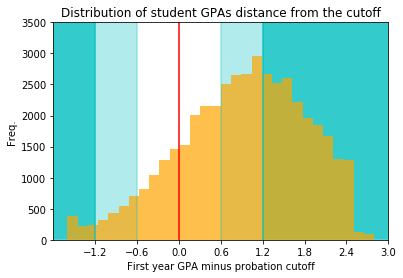

In [4]:
plot_hist_GPA(data)

In [5]:
# Reduce sample to students within 1.2 points from cutoff.
sample12 = data[abs(data['dist_from_cut']) < 1.2]
sample12.reset_index(inplace=True)
print("A sample of students within 1.2 points from the cuttoff encompasses", sample12.shape[0], "observations.")

A sample of students within 1.2 points from the cuttoff encompasses 25389 observations.


In [6]:
# Reduce sample to students within 0.6 points from cutoff.
sample06 = data[abs(data['dist_from_cut']) < 0.6]
sample06.reset_index(inplace=True)
print("The final sample includes", sample06.shape[0], "observations.")

The final sample includes 12530 observations.


Table 1 shows the descriptive statistics of the main student characteristics and outcomes in the restricted sample with a bandwidth of 0.6 from the cutoff. The majority of students is female (62%) and is a native english speaker (72%). Students in the reduced sample on average placed in the 33rd percentile in high school. It should also be noted that quite a large number of students (35%) are placed on probation after the fist year. An additional 11% are placed on probation after the first year. 

#### Table 1- Summary statistics

In [7]:
create_table1(sample06)

,Mean,Standard Deviation,Description,Type
hsgrade_pct,33.33,23.29,High School Grade Percentile,Characteristics
totcredits_year1,4.43,0.53,Credits attempted first year,Characteristics
age_at_entry,18.72,0.74,Age at entry,Characteristics
male,0.38,0.48,Male,Characteristics
english,0.72,0.45,English is first language,Characteristics
bpl_north_america,0.87,0.34,Born in North America,Characteristics
loc_campus1,0.48,0.50,At Campus 1,Characteristics
loc_campus2,0.21,0.41,At Campus 2,Characteristics
loc_campus3,0.31,0.46,At Campus 3,Characteristics
dist_from_cut,0.11,0.33,Distance from cutoff in first year,Outcomes


##  5.2. Results

### 5.2.1. Tests of the Validity of the RD Approach

The core motivation in the application of RD approaches is the idea, that the variation in treatment near the cutoff is random if subjects are unable to control the selection into treatment (Lee & Lemieux, 2010). This condition, if fulfilled, means the RDD is able to closely emulate a randomized experiment and allows researchers to identify the effects of treatment. 

For evaluating the effects of academic probation on subsequent student outcomes, the RDD is thus a valid approach only if students are not able to precisely manipulate whether they score above or below the cutoff. Lindo et al. (2010) offer multiple arguments to adress concerns about nonrandom sorting: 

1. The study focuses on **first year students**, assuming this group of students is likely to be less familiar with the probation policy on campus. To verify their conjecture, the authors also conducted a survey in an introductory economics course which revealed that around 50 % of students were unsure of the probation cutoff at their campus. They also claim that this analysis showed no relationship between knowledge of probation cutoffs and student's grades. 


2. The authors also point out that most first year courses span the entire year and most of the evaluation takes place at the end of the term which would make it difficult for students to purposely aim for performances slightly above the cutoff for academic probation.


3. Finally, and most importantly, the implication of local randomization is testable. If nonrandom sorting were to be a problem, there should be a **discontinuity** in the distribution of grades at the cutoff with a disproportionate number of students scoring just above the cutoff. Figure 1 and table 2 show the (replicated) results of tests for such discontinuities.

---
###  i.  Extension: Visual Validity Check

To check for discontinuities in the covariates and the distribution of students around the cutoff Lindo et al.(2010) use local linear regression analysis. Before implementing the rather extensive validity check conducted by Lindo et al.(2010) I show in this section that a rather simple descriptive and graphical analysis of the distribution of covariates already suggests that the continuity assumption holds.

#### Extension | Table - Descriptive Statistics of Treated and Untreated Group close to the Cutoff
The table below shows the means of the different covariates at the limits of the cutoff from both sides (here within a bandwidth of 0.1 grade points). We can see that the means of the groups below and above the probation cutoff are very similar, even equal for some of the variables.

In [8]:
cov_descriptives = describe_covariates_at_cutoff(sample06,bandwidth=0.1)
cov_descriptives

Below cutoff        Above cutoff         \
                          Mean   Std.         Mean   Std.   
hsgrade_pct              30.94  22.61        31.76  22.65   
totcredits_year1          4.42   0.55         4.37   0.54   
age_at_entry             18.73   0.76        18.72   0.75   
male                      0.38   0.49         0.38   0.49   
english                   0.70   0.46         0.72   0.45   
bpl_north_america         0.88   0.33         0.87   0.34   
loc_campus1               0.44   0.50         0.45   0.50   
loc_campus2               0.22   0.42         0.21   0.41   
loc_campus3               0.34   0.47         0.34   0.47   

                                    Description  
                                                 
hsgrade_pct        High School Grade Percentile  
totcredits_year1   Credits attempted first year  
age_at_entry                       Age at entry  
male                                       Male  
english               English is first language  
bpl_north_america         Born in North America  
loc_campus1                         At Campus 1  
loc_campus2                         At Campus 2  
loc_campus3                         At Campus 3

#### Extension | Figure - Distribution of covariates throughout the probation cutoff
The figure below shows the means of the nine covariates in bins of size 0.5 (grade points). Similar to the descriptive table shown above, this visualization shows that there seem to be no apparent discontinuities in the distribution of students for any of the observable characteristics.  

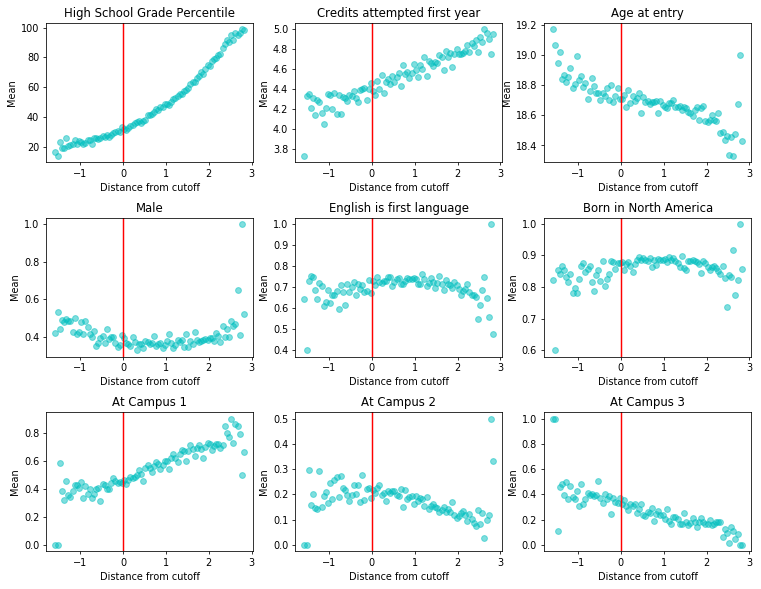

In [9]:
plot_covariates(data=data, descriptive_table=cov_descriptives,bins = 'dist_from_cut_med05')

---

### ii. Advanced Validity Check
(as conducted in Lindo et al. (2010))

#### Figure 1 | Distribution of Student Grades Relative to their Cutoff

The data (containing all observations within 1.2 GPA points from the cutoff) is sorted into bins of size 0.1. The bins contain their lower limit but not their upper limit. To replicate the result from Lindo et al., I calculate the frequency of each bin and then run a local linear regression with a bandwidth of 0.6 on each bin. Figure 1 shows the bins and the predicted frequency for each bin. The results show that the **distribution of grades is continuous around the cutoff**, suggesting that we can assume local randomization.

In [10]:
bin_frequency_fig1 = calculate_bin_frequency(sample12, "dist_from_cut_med10")
predictions_fig1 = create_bin_frequency_predictions(bin_frequency_fig1, bin_frequency_fig1.bins.unique().round(4), 0.6)

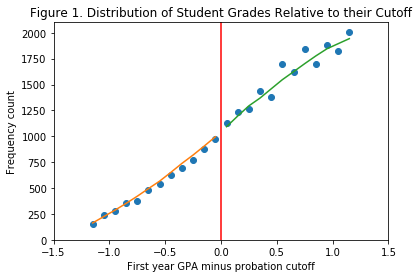

In [11]:
plot_figure1(bin_frequency_fig1, bin_frequency_fig1.bins.unique().round(4), predictions_fig1)

#### Table 2 - Estimated Discontinuities in observable characteristics 

Table 2 shows the results of local linear regression (using a bandwidth of 0.6) for a range of observable characteristics that are related to student outcomes. Significant discontinuities would indicate that students with certain characteristics might be able to manipulate their grades to score above the probation cutoff. Table 2 shows that the coefficient for scoring below the cutoff is insignificant at the 10% level for all covariates. These estimates support the validity of the RD approach. 

In [12]:
table2_variables = ('hsgrade_pct', 'totcredits_year1', 'age_at_entry', 'male', 'english', 
                    'bpl_north_america','loc_campus1', 'loc_campus2')
regressors = ['const', 'gpalscutoff', 'gpaXgpalscutoff', 'gpaXgpagrcutoff']

In [13]:
table2 = estimate_RDD_multiple_outcomes(sample06, table2_variables, regressors)
table2.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
outcomes,,,,,,,
hsgrade_pct,0.45,0.72,1.259,30.991,0,0.745,12530
totcredits_year1,0.024,0.749,0.076,4.386,0,0.046,12530
age_at_entry,0.015,0.641,0.032,18.719,0,0.021,12530
male,0,0.989,0.024,0.374,0,0.012,12530
english,-0.037,0.124,0.024,0.729,0,0.015,12530
bpl_north_america,0.017,0.173,0.013,0.864,0,0.008,12530
loc_campus1,0.012,0.724,0.034,0.444,0,0.022,12530
loc_campus2,-0.01,0.719,0.027,0.217,0,0.018,12530


In [14]:
table2 = estimate_RDD_multiple_outcomes(sample06, table2_variables, regressors)
table2.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
outcomes,,,,,,,
hsgrade_pct,0.45,0.72,1.259,30.991,0,0.745,12530
totcredits_year1,0.024,0.749,0.076,4.386,0,0.046,12530
age_at_entry,0.015,0.641,0.032,18.719,0,0.021,12530
male,0,0.989,0.024,0.374,0,0.012,12530
english,-0.037,0.124,0.024,0.729,0,0.015,12530
bpl_north_america,0.017,0.173,0.013,0.864,0,0.008,12530
loc_campus1,0.012,0.724,0.034,0.444,0,0.022,12530
loc_campus2,-0.01,0.719,0.027,0.217,0,0.018,12530


<span style="color:orange">__NOTE__:</span> My results for 'Male' and 'Age at entry' are switched compared to the table presented in Lindo et al. (2010). Since the results are identical otherwise, I assume this difference stems from an error in the table formatting of the published paper._

### 5.2.2. First year GPAs and Academic Probation

Figure 2 and the Table 3 show the estimated discontinuity in probation status. Figure 2 and the first part of Table 3 show th estimated discontinuity for the probation status after the _first year_. The second part of Table 3 presents the results for the estimated effects of scoring below the cutoff on the probability of _ever_ being placed on academic probation.

Figure 2 and part 1 of table 3 verifying that the discontinuity at the cutoff is **sharp**, i.e. all students whose GPA falls below the cutoff are placed on probation. For students below the cutoff the probability of being placed on probation is 1, for students above the cutoff it is 0.

It should be noted that the estimated discontinuity at the cutoff is only approximately equal to 1 for all of the different subgroups, as the results in part 1 of table 3 show. The authors attribute this fact to administrative errors in the data reportage. 

#### Figure 2 - Porbation Status at the End of First Year

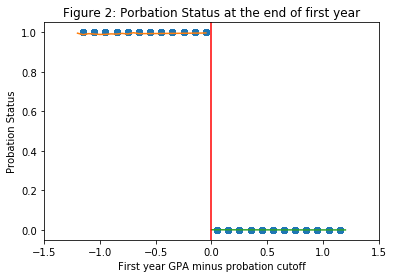

In [15]:
predictions_fig2 = create_predictions(sample12, 'probation_year1', regressors, 0.6)
plot_figure2(sample12, predictions_fig2)

#### Table 3 - Estimated Discontinuity in Probation Status

To estimate the discontinuity in probation status, the authors again use a bandwidth of 0.6 from the cutoff. In addition to the whole sample this condition applies to, they also estimate the discontinuities for certain subgroups in the sample:

* **high school grades below** and **above the median** (here, median refers to the median of the entire dataset (median: _50_) and not the median of the subset of students with a GPA within 0.6 grade points of the probation cutoff (the median for this set would be _28_))
* **male** and **female** students
* **english** native speakers and students with a different native language (**nonenglish**) 

In [16]:
sample_treat06 = sample06[sample06['dist_from_cut'] < 0]
sample_untreat06 = sample06[sample06['dist_from_cut'] >= 0]
sample06 = pd.concat([sample_untreat06, sample_treat06])

In [17]:
groups_dict_keys = ['All', 'HS Grades < median', 'HS Grades > median', 'Male', 'Female',
                    'Native English', 'Nonnative English']
groups_dict_columns = ['const', 'lowHS', 'highHS','male', 'female', 'english', 'noenglish']
groups_dict_06 = create_groups_dict(sample06, groups_dict_keys, groups_dict_columns)

**Table 3 | Part 1 - Estimated Discontinuity in Probation Status for Year 1**


In [18]:
table3_1 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 'probation_year1', regressors)
table3_1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.994,0,0.002,0.001,0.157,0.001,12530
HS Grades < median,0.995,0,0.002,0.001,0.183,0.001,9473
HS Grades > median,0.99,0,0.006,0.001,0.317,0.001,3057
Male,0.99,0,0.005,0.001,0.319,0.001,4701
Female,0.996,0,0.002,0.001,0.179,0.001,7829
Native English,0.993,0,0.002,0.001,0.16,0.001,9006
Nonnative English,0.997,0,0.003,0,0,0,3524


**Table 3 | Part 2 - Estimated Discontinuity in Probabtion Status Ever**

Part 2 of Table 3 presents the estimated effect of scoring below the cutoff in the first year for _ever_ being placed on probation. The results show that even for those who score slightly above the probation cutoff in year 1, 33 % are placed on probation at some other point in time during their studies. 

For the different subgroups of students this value varies from 29% (for students with high school grades above the median) up to 36.7% (for the group of males). These results already indicate that we can expect heterogeneities in the way different students react to being placed on academic probation.

The fact that it is not unlikely for low performing students just slightly above the cutoff to fall below it in later terms also underlines these student's fitness as a control group for the purpose of the analysis. Lindo et al. (2010) argue that the controls can be thought of as receiving a much weaker form of treatment than the group that is placed on probation, as scoring just above the cutoff in year 1 does not save students from falling below the cutoff and being placed on probation in subsequent terms. 

In [19]:
table3_1 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys,'probation_ever',regressors)
table3_1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.665,0,0.014,0.33,0,0.014,12530
HS Grades < median,0.653,0,0.014,0.343,0,0.014,9473
HS Grades > median,0.705,0,0.023,0.286,0,0.022,3057
Male,0.625,0,0.016,0.366,0,0.015,4701
Female,0.69,0,0.017,0.308,0,0.017,7829
Native English,0.677,0,0.016,0.317,0,0.016,9006
Nonnative English,0.635,0,0.023,0.362,0,0.022,3524


### 5.2.3. The Immediate Response to Academic Probation 

Students who have been placed on academic probation enter their next term at university with the threat of suspension in case they fail to improve their grades. Recalling the theoretical framework presented in prior sections, students face the following set of options after each term:

1. **Option 1**: Return to school, exhibit low effort and achieving a low GPA,
2. **Option 2**: Return to school, exhibit high effort with the intent of achieving a high GPA,
3. **Neither** option: Drop out of university.

Students on probation face a different set of choices than the students that were not placed on probation as the threat of suspension essentially eliminates option 1. Of course students could enter the next term, exhibit low effort and receive low grades but this would result in suspension. Since both option 1 and option 3 result in the student not continuing school (at least for a certain period of time), students who are not willing to exhibit high effort (and thus will be suspended) are much better off dropping out and saving themselves the cost of exhibiting low effort.

#### Table 4 - Estimated Effect on the Decision to Leave after the First Evaluation

In [20]:
table4 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 'left_school', regressors)
table4.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.018,0.01,0.007,0.041,0,0.004,12530
HS Grades < median,0.013,0.107,0.008,0.045,0,0.005,9473
HS Grades > median,0.032,0.058,0.017,0.026,0,0.007,3057
Male,0.037,0.014,0.015,0.038,0,0.007,4701
Female,0.006,0.53,0.009,0.043,0,0.004,7829
Native English,0.028,0.003,0.01,0.047,0,0.005,9006
Nonnative English,-0.004,0.713,0.011,0.025,0,0.007,3524


The results presented in table 4 and and figure 3 show the effects of being placed on probation on the probability to drop out of school after the first evaluation. 

The first row of table 4 shows the average effect of academic probation on this outcome. The results indicate that, on average, being placed on probation increases the probability of leaving university by 1.8 percentage points. A student on academic probation is thus 44% more likely to drop out than their control group counterpart.

The results presented in the rest of table 4 and and figure 3 show that the average effect of being placed on probation is also characterized by large heterogeneities between the different subgroups of students. For **males** and **native english speakers**, the results, which are significant at the 5% level, show an increase of 3.7 and 2.8 percentage points respectively in the probability of leaving university after being placed on probation after the first evaluation. The results show no significant effects for these group's counterparts, the subgroups of females and nonnative english speakers. 

Aside from gender and native language, the results also indicate that high school performance seems to play a role in how students react on being placed on probation. For the group of students who scored **above the median in high school** academic probation roughly doubles the probability of leaving school compared to the control group while there is no such effect for students who scored below the median in high school. Lindo et al. (2010) contribute this finding to a discouragement effect for those students who are placed on probation.

#### Figure 3 - Stratified Results for Voluntarily Leaving School at the End of the First year

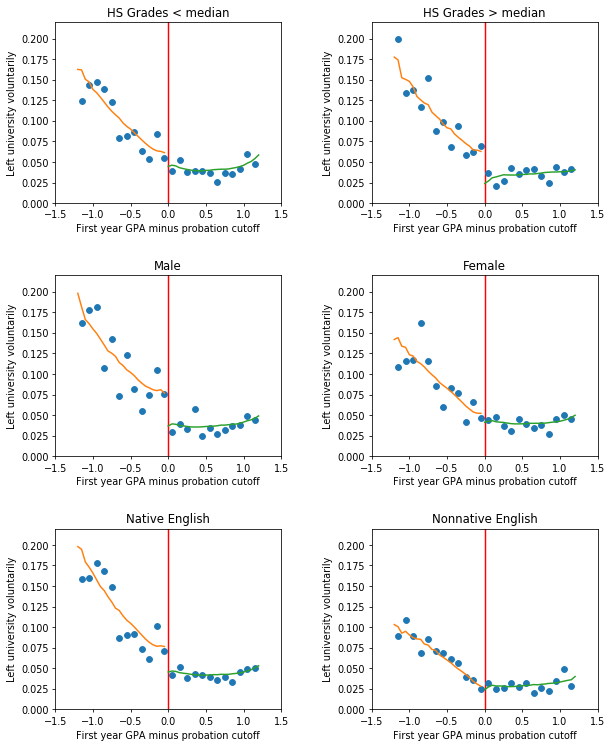

In [21]:
groups_dict_12 = create_groups_dict(sample12, groups_dict_keys, groups_dict_columns)
predictions_groups_dict = create_fig3_predictions(groups_dict_12, regressors, 0.6)
plot_figure3(groups_dict_12, predictions_groups_dict, groups_dict_keys)

### 5.2.4. The Impact on Subsequent Performance (WIP)

The next outcome Lindo et al. (2010) analyze is the performance of students who stayed at university for the next term.

#### Table 5 - Estimated Discontinuites in subsequent GPA | Part A - Next Term GPA

In [22]:
table5 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 'nextGPA', regressors)
table5.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.233,0,0.026,0.312,0,0.018,11258
HS Grades < median,0.247,0,0.029,0.275,0,0.02,8457
HS Grades > median,0.179,0.028,0.081,0.443,0,0.044,2801
Male,0.207,0,0.044,0.281,0,0.027,4166
Female,0.246,0,0.036,0.33,0,0.024,7092
Native English,0.229,0,0.036,0.309,0,0.02,8012
Nonnative English,0.24,0,0.055,0.318,0,0.035,3246


#### Table 5 - Estimated Discontinuites in subsequent GPA | Part B - Probability of improving GPA in next term

Panel B of table 5 shows the probability of scoring above the cutoff in the next term. The next term can refer to the next academic year but also summer classes that only some students enroll for.

In [23]:
table5 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys,'nextGPA_above_cutoff', regressors)
table5.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.099,0,0.014,0.693,0,0.009,11258
HS Grades < median,0.109,0,0.017,0.68,0,0.011,8457
HS Grades > median,0.061,0.073,0.034,0.737,0,0.02,2801
Male,0.075,0.001,0.022,0.68,0,0.013,4166
Female,0.111,0,0.022,0.7,0,0.014,7092
Native English,0.112,0,0.02,0.691,0,0.011,8012
Nonnative English,0.07,0.004,0.024,0.697,0,0.019,3246


#### Figure 4 - GPA in the next enrolled term

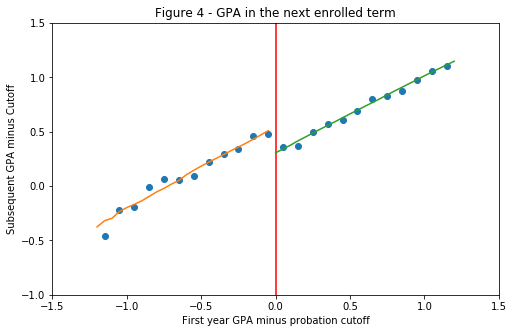

In [24]:
predictions_fig4 = create_predictions(sample12, 'nextGPA', regressors, 0.6)
plot_figure4(sample12, predictions_fig4)

### 5.2.5. The Impacts on Graduation

As a third outcome, Lindo et al. (2010) examine the effects of academic probation on student's graduation rates. As already discussed in the previous section, the outcomes that are realized later in time are more complex to examine because of all the different choices a student has made until she or he reaches that outcome. Graduation rates are the process of a dynamic decision making process that spans throughout the student's time at university. While the study focuses mainly on the effects of being put on probation after year 1, the decision problem described in the theoretical framework can be faced by a students at different points during their academic career as students can be placed on probation each term. Indeed, out of all the students who are ever placed on probation, 20% are put on probation in later terms. There are different ways in which academic probation could affect graduation rates. On the one hand it could reduce the probability of graduating because probation increases the probability of dropping out and some students who fail to increase their grades are suspended. On the other hand, these students might have not made it to graduation anyway and thus not have an effect. Additionally, probation could increase graduation rates because those students who remain improve their performance. Analyzing these effects is complicated because they are the product of multiple periods in which students can be placed on probation and make according decisions. 

#### Figure 5 - Graduation Rates

Figure 5 and the different parts of table 6 show the estimated impacts of academic probation after the first year on whether a students has graduated in four, five or six years. The effects are negative for all three options, suggesting that the negative effects discussed above overweigh potential positive effects on graduation rates.

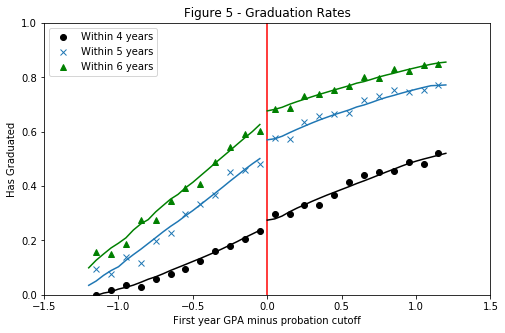

In [26]:
plot_figure5(sample12, 
             create_predictions(sample12,'gradin4', regressors, 0.6), 
             create_predictions(sample12,'gradin5', regressors, 0.6), 
             create_predictions(sample12,'gradin6', regressors, 0.6))

#### Table 6 - Estimated Effects on Graduation

The effects on graduation rates are insignificant for most subgroups, the group of students with high school grades above the median stands out as being especially negatively affected by being placed on probation in the first year. This group of students sees their probability of graduation within six years reduced by 14.5 percent. Lindo et al. (2010) attribute these results to the fact that this group of students is especially likely to drop out after being put on probation and also on average does not do much better than their counterpart if they continue to attend university.

Overall the results on graduation rates are rather weak. This likely partially stems from the more complex nature in which probation in the first year can affect this outcome. Unfortunately, most of the data in the provided dataset focuses on the first two years of students' time at university. Much more information would be needed to uncover the mechanisms in which probation may affect students probability of graduating within specific timeframes.

<span style="color:orange">__NOTE__:</span> Below I only show the sections of table 6 that are discussed above as the entire table is quite extensive. The other results presented in table 6 of the paper can be viewed by commenting out the code at the end of this section.

#### Graduated after 6 years

In [27]:
table6 = create_table6(groups_dict_06, groups_dict_keys, regressors)
table6.loc[['All','HS Grades > median' ], 
           'Graduated after 6 years'].style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.024,0.316,0.024,0.674,0,0.018,6005
HS Grades > median,-0.145,0.006,0.053,0.76,0,0.022,1356


**Code for all of table 6:**

In [28]:
# table6.loc[:, 'Graduated after 4 years'].style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

In [29]:
# table6.loc[:, 'Graduated after 5 years'].style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

In [ ]:
# table6.loc[:, 'Graduated after 6 years'].style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

---
# 6. Robustness Checks (wip)
---

## 6.1.  A closer look at student's subsequent performance. 

The results from Lindo et al. (2010) presented above, show that students are more likely to drop out after being placed on academic probation but those who remain in school tend to improve their GPA above the cutoff in the next term. These results are generally in line with the theoretical framework presented in the paper which predicts that students either drop out or improve their GPA if the cost of not improving in the next term increases. The performance standard model explains these results through students self selecting between increasing effort and dropping out based on their abilities (which are defined as the probability of meeting the performance standard). Students who are less likely to improve their GPA should thus be more likely to drop out. Unfortunately,it is not possible to test this prediction, as Lindo et al. (2010) emphasize in the paper, because the probability of meeting the performance standard is not observed for students who leave school. 

However, examining the students who remain in school may give some further insights. While Lindo et al. (2010) observe that  students have been placed on probation on average improve their performance, they do not analyze under which circumstances this is happening. A look at the amount of credits students are taking in their second year may give some insights. The results presented below show that being placed on probation after the first year has a negative effect on the amount of credits students take in year 2 for all of the examined subgroups except the group of non-english speakers. This is the stark contrast the first year where both the treatment and control group take almost the same amount of credits (as shown in the section on the Validity of the RD Approach).

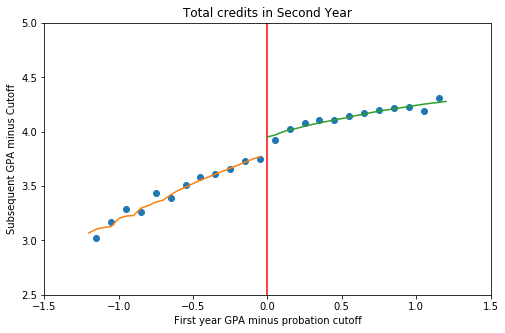

In [ ]:
predictions_credits_year2 = create_predictions(sample12, 'total_credits_year2', regressors, 0.6)
plot_figure_credits_year2(sample12, predictions_credits_year2)

The results indicate that being placed on probation decreases the total credits taken by the average student in year two by 0.16, around 4% of the control mean. As the table below shows, the results are again most prominent for males, native english speakers and students with high school grades above the median, the same group of students that were most affected in the other outcomes. 

In [ ]:
table_total_credits_year2 = estimate_RDD_multiple_datasets(groups_dict_06, groups_dict_keys, 
                                                           'total_credits_year2',regressors)
table_total_credits_year2.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.164,0.004,0.057,3.953,0,0.036,10844
HS Grades < median,-0.126,0.047,0.063,3.906,0,0.04,8114
HS Grades > median,-0.296,0.003,0.099,4.115,0,0.041,2730
Male,-0.201,0.016,0.083,3.839,0,0.049,3996
Female,-0.15,0.015,0.061,4.021,0,0.043,6848
Native English,-0.184,0,0.05,4.029,0,0.032,7766
Nonnative English,-0.088,0.433,0.112,3.756,0,0.067,3078


When interpreting these results it should be kept in mind that some student's next evaluation takes place during summer classes. Students who have taken summer classes enter their second year already having passed the next evaluation or not. Those who fell below the cutoff will have been suspended and thus are missing from the data for the second year and those who have passed the threshold in the summer classes are likely not on probation anymore. Estimating the effects of probation on credits taken in the second year separately for both groups shows that those who did not take classes in the summer are more affected than those who did. For the students who took summer classes, the results are only significant for males, students with high school grades above the median and native english speakers.

#### No summer classes

In [ ]:
sample06_nosummer = sample06[sample06.summerreg_year1 == 0]
groups_dict_06_nosummer = create_groups_dict(data=sample06_nosummer, keys=groups_dict_keys,columns=groups_dict_columns)
table_totcred_y2_nosummer = estimate_RDD_multiple_datasets(groups_dict_06_nosummer,groups_dict_keys,
                                                           'total_credits_year2',regressors)
table_totcred_y2_nosummer.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.187,0,0.048,4.112,0,0.03,6820
HS Grades < median,-0.192,0.002,0.062,4.088,0,0.034,5137
HS Grades > median,-0.173,0.058,0.091,4.204,0,0.045,1683
Male,-0.155,0.042,0.076,3.988,0,0.049,2653
Female,-0.22,0,0.058,4.197,0,0.042,4167
Native English,-0.183,0.001,0.053,4.143,0,0.032,5333
Nonnative English,-0.173,0.044,0.086,3.99,0,0.062,1487


#### Summer classes

In [ ]:
sample06_summer = sample06[sample06.summerreg_year1 == 1]
groups_dict_06_summer = create_groups_dict(sample06_summer,groups_dict_keys,groups_dict_columns)
table_totcred_y2_summer = estimate_RDD_multiple_datasets(groups_dict_06_summer,groups_dict_keys,
                                                         'total_credits_year2',regressors)
table_totcred_y2_summer.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.176,0.077,0.099,3.725,0,0.058,4024
HS Grades < median,-0.071,0.521,0.111,3.646,0,0.061,2977
HS Grades > median,-0.541,0.004,0.188,3.989,0,0.096,1047
Male,-0.336,0.044,0.167,3.577,0,0.072,1343
Female,-0.093,0.365,0.102,3.798,0,0.07,2681
Native English,-0.251,0.017,0.106,3.818,0,0.058,2433
Nonnative English,-0.053,0.767,0.179,3.577,0,0.093,1591


These findings are useful for interpreting the subsequent performance of students because more credits likely signify a larger workload for the student. Instead of increasing their effort, students may just decrease their workload by completing less credits in the next term. Unfortunately, we cannot test this in detail because the data doesn't shows how many credits students completed in which term. 

Reducing the sample for the analysis of the subsequent GPA to students who did not attend summer classes and completed 4 credits in the second year (the most frequent amount of credits take by this group of students) shows that the effect of scoring below the cutoff in year 1 becomes insignificant for the students who have above median high school grades and non-native english speakers. The improvement decreases a bit for some groups like females or students with high school grades below the median but increases for others like males and native english speakers. Overall the results are still highly significant though considering the small window to which the data is reduced in this case. 

In [ ]:
sample06_many_credits = sample06_nosummer[(sample06_nosummer.total_credits_year2 == 4)]
groups_dict_06_manycredits = create_groups_dict(sample06_many_credits,groups_dict_keys,groups_dict_columns)
table_manycredits = estimate_RDD_multiple_datasets(groups_dict_06_manycredits,groups_dict_keys,
                                                         'nextGPA',regressors)
table_manycredits.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.188,0,0.047,0.314,0,0.027,2003
HS Grades < median,0.22,0,0.052,0.265,0,0.035,1524
HS Grades > median,0.072,0.586,0.132,0.476,0,0.073,479
Male,0.273,0.001,0.082,0.289,0,0.046,748
Female,0.144,0.031,0.067,0.331,0,0.04,1255
Native English,0.252,0,0.055,0.272,0,0.032,1578
Nonnative English,-0.051,0.609,0.1,0.473,0,0.062,425


Overall these results suggest that while the results on subsequent GPA discussed in Lindo et al.(2010) seem to be quite robust, the different ways in which students could react to academic probation in trying to avoid suspension should not be overlooked. 

## 6.2. Placebo threshold (WIP)

To test the robustness of the results from the paper presented in my replication, I implement a placebo regression. This means I define a new fictional cutoff point and run the regressions from the previous parts based on the distances from the fictional cutoff. Artificially increasing the probation threshold in our data means that in the new regression, some students will be counted towards the treatment group even though in reality, they were not put on probation since they scored above the actual cutoff. 

In [ ]:
def plot_hist_GPA(data):
    plt.pyplot.xlim(-1.8, 3)
    plt.pyplot.ylim(0, 3500)
    plt.pyplot.xticks([-1.2,-0.6,0,0.6,1.2,1.8,2.4,3])
    plt.pyplot.hist(data['dist_from_cut'], bins=30, color='orange', alpha=0.7)
    plt.pyplot.axvline(x=-1.2, color='c',alpha=0.8)
    plt.pyplot.axvline(x=1.2, color='c',alpha=0.8)
    plt.pyplot.axvline(x=0.6, color='c',alpha=0.3)
    plt.pyplot.axvline(x=-0.6, color='c',alpha=0.3)
    plt.pyplot.axvline(x=0, color='r')
    plt.pyplot.fill_betweenx(y=range(3500),x1=-1.8,x2=-1.2,alpha=0.8, facecolor='c')
    plt.pyplot.fill_betweenx(y=range(3500),x1=-1.2,x2=-0.6,alpha=0.3,facecolor='c')
    plt.pyplot.fill_betweenx(y=range(3500),x1=1.2,x2=0.6,alpha=0.3,facecolor='c')
    plt.pyplot.fill_betweenx(y=range(3500),x1=3,x2=1.2,alpha=0.8,facecolor='c')
    plt.pyplot.xlabel('First year GPA minus probation cutoff')
    plt.pyplot.ylabel('Freq.')
    plt.pyplot.title('Distribution of student GPAs distance from the cutoff')

### 6.2.1. Placebo regression for a cutoff that is _0.3 GPA points higher_ than the actual probation cutoff
I first increase the threshold point by 0.3 GPA points i.e. if the probation cutoff was at a GPA of 1.7 before, it is now at 2.0

In [ ]:
placebo1_data = gen_placebo_data(data=data, cutoff_deviation=(0.3))
placebo1_data12 = create_placebo_subdata(placebo_data=placebo1_data)[0]
placebo1_data06 = create_placebo_subdata(placebo_data=placebo1_data)[1]
placebo1_groups_dict_06 = create_groups_dict(placebo1_data06, groups_dict_keys, groups_dict_columns)
placebo1_reg_table = estimate_RDD_multiple_datasets(placebo1_groups_dict_06, groups_dict_keys, 'left_school', regressors)
placebo1_reg_table.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,-0.009,0.158,0.006,0.04,0,0.004,16151
HS Grades < median,-0.002,0.83,0.008,0.038,0,0.005,11154
HS Grades > median,-0.027,0.019,0.011,0.044,0,0.007,4997
Male,-0.022,0.043,0.011,0.041,0,0.008,5988
Female,-0,0.993,0.008,0.039,0,0.006,10163
Native English,-0.01,0.157,0.007,0.044,0,0.005,11726
Nonnative English,-0.005,0.672,0.011,0.029,0,0.006,4425


### 6.2.2. Placebo regression for a cutoff that is _0.6 GPA points higher_ than the actual probation cutoff
I first increase the threshold point by 0.6 GPA points i.e. if the probation cutoff was at a GPA of 1.7 before, it is now at 2.3.

In [ ]:
placebo2_data = gen_placebo_data(data=data, cutoff_deviation=(0.6))
placebo2_data12 = create_placebo_subdata(placebo_data=placebo2_data)[0]
placebo2_data06 = create_placebo_subdata(placebo_data=placebo2_data)[1]
placebo2_groups_dict_06 = create_groups_dict(placebo2_data06, groups_dict_keys, groups_dict_columns)
placebo2_reg_table = estimate_RDD_multiple_datasets(placebo2_groups_dict_06, groups_dict_keys, 'left_school', regressors)
placebo2_reg_table.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.008,0.133,0.006,0.029,0,0.004,18794
HS Grades < median,0.011,0.121,0.007,0.025,0,0.005,11696
HS Grades > median,0.008,0.389,0.009,0.033,0,0.007,7098
Male,0.009,0.251,0.008,0.027,0,0.005,6917
Female,0.008,0.246,0.007,0.03,0,0.005,11877
Native English,0.007,0.306,0.007,0.032,0,0.005,13748
Nonnative English,0.013,0.114,0.008,0.021,0,0.005,5046


In [ ]:
placebo1_pred = create_predictions(data=placebo1_data12, outcome='left_school', regressors=regressors, bandwidth=0.6)
placebo2_pred = create_predictions(data=placebo2_data12, outcome='left_school', regressors=regressors, bandwidth=0.6)

Text(0.5,1,'Left university voluntarily | Deviation from cutoff: 0.6')

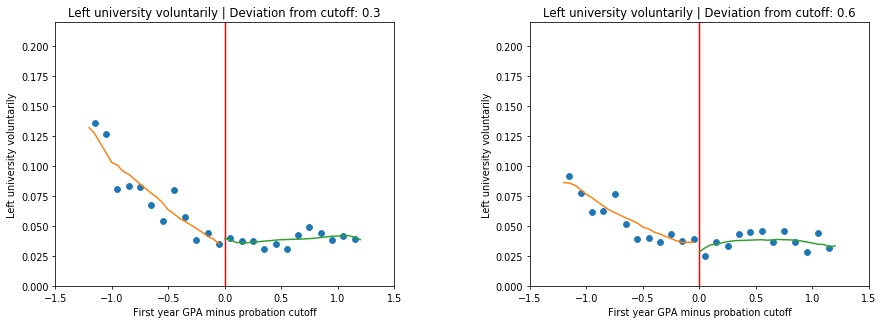

In [ ]:
plt.pyplot.figure(figsize=(15, 5), dpi=70, facecolor='w', edgecolor='k')
plt.pyplot.subplots_adjust(wspace=0.4, hspace=0.4)

plt.pyplot.subplot(1, 2, 1)
plt.pyplot.xlim(-1.5, 1.5, 0.1)
plt.pyplot.ylim(0, 0.22, 0.1)
plt.pyplot.axvline(x=0, color='r')
plt.pyplot.xlabel('First year GPA minus probation cutoff')
plt.pyplot.ylabel('Left university voluntarily')
bin_means = placebo1_data12.left_school.groupby(placebo1_data12['dist_from_cut_med10']).mean()
bin_means = pd.Series.to_frame(bin_means)
plt.pyplot.plot(list(bin_means.index),list(bin_means.left_school), 'o')
plot_RDD_curve(df=placebo1_pred, running_variable="dist_from_cut",outcome="prediction", cutoff=0)
plt.pyplot.title("Left university voluntarily | Deviation from cutoff: 0.3")


plt.pyplot.subplot(1, 2, 2)
plt.pyplot.xlim(-1.5, 1.5, 0.1)
plt.pyplot.ylim(0, 0.22, 0.1)
plt.pyplot.axvline(x=0, color='r')
plt.pyplot.xlabel('First year GPA minus probation cutoff')
plt.pyplot.ylabel('Left university voluntarily')
bin_means = placebo2_data12.left_school.groupby(placebo2_data12['dist_from_cut_med10']).mean()
bin_means = pd.Series.to_frame(bin_means)
plt.pyplot.plot(list(bin_means.index),list(bin_means.left_school), 'o')
plot_RDD_curve(df=placebo2_pred, running_variable="dist_from_cut",outcome="prediction", cutoff=0)
plt.pyplot.title("Left university voluntarily | Deviation from cutoff: 0.6")

## 6.3. Bootstrap Confidence Intervals (WIP)

### 6.3.1. Subsequent performance with 95% Confidence Interval

In [ ]:
bootstrap_pred = bootstrap_predictions(n=100, data=sample12, outcome='nextGPA', regressors=regressors, bandwidth=0.6)
CI = get_confidence_interval(data=bootstrap_pred, lbound=2.5, ubound=97.5, index_var='dist_from_cut')
predictions_fig4_CI = pd.concat([predictions_fig4, CI[['upper_bound', 'lower_bound']]], axis=1)

In [ ]:
plot_figure4_with_CI(data=sample12, pred=predictions_fig4_CI)

---
# 7. Conclusion
---

---
# 8. References
---

* **Bénabou, R., & Tirole, J. (2000)**. *Self-confidence and social interactions* (No. w7585). National bureau of economic research.


* **Thistlethwaite, D. L., & Campbell, D. T. (1960)**. Regression-discontinuity analysis: An alternative to the ex post facto experiment. *Journal of Educational psychology*, 51(6), 309.


* **Lee, D. S., & Lemieux, T. (2010)**. Regression discontinuity designs in economics. *Journal of economic literature*, 48(2), 281-355.


* **Lindo, J. M., Sanders, N. J., & Oreopoulos, P. (2010)**. Ability, gender, and performance standards: Evidence from academic probation. *American Economic Journal: Applied Economics*, 2(2), 95-117.
 

-------
                                          Notebook by Annica Gehlen | Find me on Github under https://github.com/amageh

---